In [1]:
import torch
from tqdm import tqdm
from dataset import DataSet
import argparse
from models import WrapperI3D
import pandas as pd
from milforvideo.video import Extractor, VideoFeature
from torchvision import transforms
from PIL import Image
import os
import cv2
import numpy as np


PATHLIST = "/datasets/UCSD_Anomaly_Dataset_v1p2/ped1_test.txt"

def open_image(path: str, resize: float = 1.0) -> Image.Image:
    assert os.path.exists(path)
    img = cv2.imread(path)
    return cv2.resize(img, dsize=None, fx=resize, fy=resize)
        

def get_mask_path(path):
    TXT = "Test000/000.tif"
    return path[:-len(TXT)] + path[-len(TXT):-len("Test000") - 1] + "_gt/" + os.path.basename(path).replace(".tif", ".bmp")

def open_mask(path: str, resize: float = 1.0) -> Image.Image:
    mask_path = get_mask_path(path)
    if os.path.exists(mask_path):
        return open_image(mask_path, resize)
    else:
        return np.zeros(open_image(path, resize).shape, dtype=np.uint8)

def img2tensor(paths, background, reverse_mask):    
    filter_value = 0 if reverse_mask else 255  
    return torch.stack([
        torch.tensor(np.where(
            open_mask(path) == filter_value, 
            open_image(path), 
            background))
        for path in paths
    ])



In [2]:

with open(PATHLIST) as f:
    grp_path_and_label = [
        row.split(" ")
        for row in f.read().split("\n")
        if row
    ]
    df = pd.DataFrame({
        "grp": [int(grp) for grp, _, _ in grp_path_and_label],
        "path": [path for _, path, _ in grp_path_and_label],
        "label": [int(label) for _, _, label in grp_path_and_label],
    })

net = WrapperI3D()
for idx, df_grp in df.groupby('grp'):
    background = np.median([
        open_image(path)
        for path in df_grp["path"].tolist()
    ], axis=0).astype(np.uint8)
    extractor_mask = Extractor(
        df_grp["path"].tolist(), 
        df_grp["label"].tolist(), 
        net, lambda paths: img2tensor(paths, background, reverse_mask=True),
        F=16,
        aggregate=max,
        cuda=True)
    break

In [3]:
extractor_mask.images().__getitem__(0).size()

torch.Size([16, 158, 238, 3])

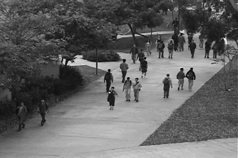

In [4]:
Image.fromarray(extractor_mask.images().__getitem__(0)[0].numpy())